In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
CDC_forecasts_counties = pd.read_csv("../rawdata/2021-02-01-all-forecasted-cases-model-data.csv")
CDC_hospitalizations_states = pd.read_csv("../rawdata/2021-02-01-all-hospitalizations-model-data.csv")
HHS_data = pd.read_csv("../rawdata/reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20210207.csv")
HHS_data = HHS_data.replace({-999999.0: 2})
MD_data  = HHS_data# [HHS_data.state == 'MD']

# Achieving the number of hospitalizations in the dates that CDC forecasts cases

In [3]:
template_df_state = pd.DataFrame({'county_name': [], 'fips': []})
count = 2
for collection_date in CDC_forecasts_counties.target_end_date.unique():    
    template_df_state.insert(count, 'forecasted_hospitalizations_' +collection_date, [], True) 
    count += 1
output_CDC_US = template_df_state.copy()
for state in CDC_forecasts_counties.State.unique():
    state_forecast_mean = CDC_forecasts_counties[(CDC_forecasts_counties.location_name == state) & (CDC_forecasts_counties.target_end_date == CDC_forecasts_counties.target_end_date.unique()[0])].point.mean() / 7
    state_hospitalizations_mean = CDC_hospitalizations_states[CDC_hospitalizations_states.target_end_date == CDC_forecasts_counties.target_end_date.unique()[0]].point.mean() 
    if (state_forecast_mean != 0) and (state_forecast_mean != 0):
        state_ratio_of_hospitalizations = state_hospitalizations_mean / state_forecast_mean 
    else:
        state_ratio_of_hospitalizations = 1
    state_forecast_data = CDC_forecasts_counties[CDC_forecasts_counties.State == state]
    temp_output_df = pd.DataFrame({'county_name': state_forecast_data.location_name.unique(), 'fips': state_forecast_data.fips.unique()[0:state_forecast_data.location_name.unique().shape[0]]})
    for collection_date in state_forecast_data.target_end_date.unique():
        state_forecast_mean = np.zeros(state_forecast_data.location_name.unique().shape[0])
        state_hospitalizations_mean = np.zeros(state_forecast_data.location_name.unique().shape[0])    
        count = 0
        for location in state_forecast_data.location_name.unique():
            state_forecast_mean [count] = state_forecast_data[(state_forecast_data.location_name == location) & (state_forecast_data.target_end_date == collection_date)].point.mean() / 7
            state_hospitalizations_mean[count] = state_forecast_mean[count] * state_ratio_of_hospitalizations
            count += 1
        temp_output_df['forecasted_hospitalizations_' +collection_date] = state_forecast_mean  
    output_CDC_US = output_CDC_US.append(temp_output_df)
states_array = np.zeros (output_CDC_US.fips.shape[0],dtype ='object')
count = 0
for fips in np.array(output_CDC_US.fips):
    states_array[count] = CDC_forecasts_counties[CDC_forecasts_counties.fips == fips[0:2]].State.unique()[0]   
    count+=1
output_CDC_US['state'] = states_array

In [4]:
output_CDC_US_hospitalizations = pd.DataFrame({'county_name': output_CDC_US.county_name.unique(),
                                               'state': output_CDC_US.state,
                                         'fips': output_CDC_US.fips})
week_dates = CDC_forecasts_counties.target_end_date.unique()
US_hospitalizations_mean = np.zeros(output_CDC_US_hospitalizations.county_name.unique().shape[0])
count = 0
for collection_date in CDC_hospitalizations_states.target_end_date.unique():
    if count <= 4:
        count_2 = 0
        for county in output_CDC_US_hospitalizations.county_name.unique():
            state = np.array(output_CDC_US_hospitalizations[output_CDC_US_hospitalizations.county_name == county].state)[0]
            US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) & 
                                                                            (CDC_hospitalizations_states.location_name   == state)].point.mean() * np.array(output_CDC_US[output_CDC_US.county_name == county]['forecasted_hospitalizations_' + week_dates[0]])[0]/np.array(output_CDC_US[output_CDC_US.county_name == state]['forecasted_hospitalizations_' + week_dates[0]])[0]
            count_2 +=1
        output_CDC_US_hospitalizations['forecasted_hospitalizations_' +collection_date] = US_hospitalizations_mean
        count += 1 
    elif ((count >= 5) and (count <= 11)):
        count_2 = 0
        for county in output_CDC_US_hospitalizations.county_name.unique():
            state = np.array(output_CDC_US_hospitalizations[output_CDC_US_hospitalizations.county_name == county].state)[0]
            US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) & 
                                                                            (CDC_hospitalizations_states.location_name   == state)].point.mean() * np.array(output_CDC_US[output_CDC_US.county_name == county]['forecasted_hospitalizations_' + week_dates[1]])[0]/np.array(output_CDC_US[output_CDC_US.county_name == state]['forecasted_hospitalizations_' + week_dates[1]])[0]
            count_2 +=1
        output_CDC_US_hospitalizations['forecasted_hospitalizations_' +collection_date] = US_hospitalizations_mean
        count += 1 
    elif (count >= 12) & (count <= 18):
        count_2 = 0
        for county in output_CDC_US_hospitalizations.county_name.unique():
            state = np.array(output_CDC_US_hospitalizations[output_CDC_US_hospitalizations.county_name == county].state)[0]
            US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) & 
                                                                            (CDC_hospitalizations_states.location_name   == state)].point.mean() * np.array(output_CDC_US[output_CDC_US.county_name == county]['forecasted_hospitalizations_' + week_dates[2]])[0]/np.array(output_CDC_US[output_CDC_US.county_name == state]['forecasted_hospitalizations_' + week_dates[2]])[0]
            count_2 +=1
        output_CDC_US_hospitalizations['forecasted_hospitalizations_' +collection_date] = US_hospitalizations_mean
        count += 1   
    elif (count >= 19) & (count <= 25):
        count_2 = 0
        for county in output_CDC_US_hospitalizations.county_name.unique():
            state = np.array(output_CDC_US_hospitalizations[output_CDC_US_hospitalizations.county_name == county].state)[0]
            US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) & 
                                                                            (CDC_hospitalizations_states.location_name   == state)].point.mean() * np.array(output_CDC_US[output_CDC_US.county_name == county]['forecasted_hospitalizations_' + week_dates[3]])[0]/np.array(output_CDC_US[output_CDC_US.county_name == state]['forecasted_hospitalizations_' + week_dates[3]])[0]
            count_2 +=1
        output_CDC_US_hospitalizations['forecasted_hospitalizations_' +collection_date] = US_hospitalizations_mean
        count += 1    

<ipython-input-4-fd3c5914a0d0>:12: RuntimeWarning: invalid value encountered in double_scalars
  US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) &
<ipython-input-4-fd3c5914a0d0>:21: RuntimeWarning: invalid value encountered in double_scalars
  US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) &
<ipython-input-4-fd3c5914a0d0>:30: RuntimeWarning: invalid value encountered in double_scalars
  US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) &
<ipython-input-4-fd3c5914a0d0>:39: RuntimeWarning: invalid value encountered in double_scalars
  US_hospitalizations_mean[count_2] = CDC_hospitalizations_states[(CDC_hospitalizations_states.target_end_date == collection_date) &


<ipython-input-5-dbfac67bff53>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MD_latest_hospitalization_percentages_county_level.hospitalization_percentage[count] = MD_data[MD_data.ccn == MD_latest_hospitalization_percentages_county_level.ccn[count]].hospitalization_percentage.mean()


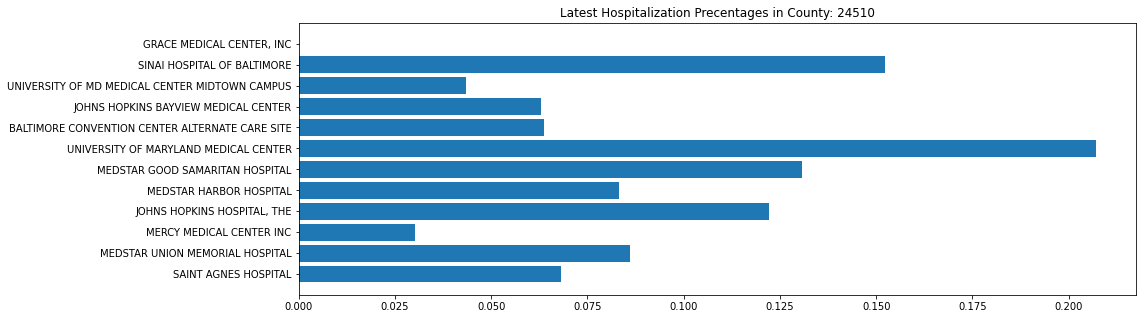

In [5]:
def get_percentages (MD_data, attribute):
    hospitalization_percentage = np.zeros([MD_data.collection_week.shape[0]])
    count = 0
    for index, row in MD_data.iterrows():
        temp_df_0 = MD_data[(MD_data.collection_week == np.array(MD_data[MD_data.index == index].collection_week)[0]) &
                        (MD_data.fips_code == np.array(MD_data[MD_data.index == index].fips_code)[0])] 
        sum_hospitalizations = temp_df_0[attribute].sum()
        if sum_hospitalizations == 0: sum_hospitalizations = 1
        hospitalization_percentage [count] = MD_data[attribute][index] / sum_hospitalizations
        count += 1
    MD_data ['hospitalization_percentage'] = hospitalization_percentage
    ICU_percentages = MD_data.staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum / MD_data.total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum
    MD_data ['ICU_percentages'] = ICU_percentages
    MD_latest_hospitalization_percentages_county_level = MD_data[MD_data.collection_week == MD_data ['collection_week'].unique()[0]][['hospital_name', 'ccn' ,'collection_week', 'fips_code' , 'hospitalization_percentage', 'ICU_percentages']]
    count = 0
    for hospital in MD_latest_hospitalization_percentages_county_level.hospital_name:
        MD_latest_hospitalization_percentages_county_level.hospitalization_percentage[count] = MD_data[MD_data.ccn == MD_latest_hospitalization_percentages_county_level.ccn[count]].hospitalization_percentage.mean()
        count += 1
    plt.figure(figsize=(15,5))
    plt.barh(MD_latest_hospitalization_percentages_county_level[MD_latest_hospitalization_percentages_county_level.fips_code == 24510].hospital_name,
            MD_latest_hospitalization_percentages_county_level[MD_latest_hospitalization_percentages_county_level.fips_code == 24510].hospitalization_percentage)
    plt.tick_params(axis='x', rotation=0)
    plt.title('Latest Hospitalization Precentages in County: 24510')
    MD_latest_hospitalization_percentages_county_level[MD_latest_hospitalization_percentages_county_level.fips_code == 24510]    
    return MD_latest_hospitalization_percentages_county_level
attribute = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum'
MD_latest_hospitalization_percentages_county_level = get_percentages (MD_data, attribute)

In [14]:
output_CDC_US_hospitalizations.to_csv('tmp/output_CDC_US.csv')  
output_CDC_MD = pd.read_csv("tmp/output_CDC_US.csv")
#output_CDC_MD = output_CDC_US_hospitalizations
output_CDC_MD = output_CDC_MD.drop(output_CDC_MD[output_CDC_MD.fips == 'US'].index[0])
output_CDC_MD.at[output_CDC_MD['fips'][output_CDC_MD.state == 'District of Columbia'].index[0], 'fips'] = 11001
output_CDC_MD.fips = output_CDC_MD.fips.astype('int64')
mapping_dates_df = pd.DataFrame({'column_name' : output_CDC_MD.columns[4:],
    'collection_date': CDC_hospitalizations_states.target_end_date.unique()[0:output_CDC_MD.columns[4:].shape[0]]})
MD_latest_hospitalization_percentages_county_level = MD_latest_hospitalization_percentages_county_level[MD_latest_hospitalization_percentages_county_level.fips_code.isin(output_CDC_MD.fips)]
#MD_latest_hospitalization_percentages_county_level[MD_latest_hospitalization_percentages_county_level.fips_code == 11001]
hospitalizations = np.zeros(MD_latest_hospitalization_percentages_county_level.hospital_name.shape)
for collection_date in mapping_dates_df.collection_date.unique():
    count = 0
    for hospital in MD_latest_hospitalization_percentages_county_level.hospital_name:
        temp_df = MD_latest_hospitalization_percentages_county_level[MD_latest_hospitalization_percentages_county_level.hospital_name == hospital]
        date_temp_df = mapping_dates_df[mapping_dates_df.collection_date == collection_date]
        hospitalizations[count] = np.array(temp_df.hospitalization_percentage)[0] * np.array(output_CDC_MD[output_CDC_MD['fips'] == np.array(temp_df.fips_code)[0]][np.array(date_temp_df.column_name)[0]])[0]
        count += 1
    MD_latest_hospitalization_percentages_county_level['hospitalization_' + collection_date] = hospitalizations
#MD_latest_hospitalization_percentages_county_level.to_csv(r'C:\Users\farzi\OneDrive - Johns Hopkins\Research\COVID-19\Resource Allocation\Code - HHS histroical data\output_HHS_US_2021-01-30.csv') 
#MD_latest_hospitalization_percentages_county_level[MD_latest_hospitalization_percentages_county_level.fips_code == 11001]

MD_hospitalizations_one_column = MD_latest_hospitalization_percentages_county_level[['hospital_name', 'ccn', 'collection_week', 'fips_code', 'hospitalization_percentage', 'ICU_percentages' ,MD_latest_hospitalization_percentages_county_level.columns[6]]].copy()
MD_hospitalizations_one_column['target_date'] = np.full((MD_latest_hospitalization_percentages_county_level.hospital_name.shape[0]), '2021-01-19')
for collection_date in mapping_dates_df.collection_date[1:]:
    temp_df = MD_latest_hospitalization_percentages_county_level[['hospital_name', 'ccn', 'collection_week', 'fips_code', 'hospitalization_percentage', 'ICU_percentages' ,'hospitalization_' + collection_date]].copy()
    temp_df['target_date'] = np.full((MD_latest_hospitalization_percentages_county_level.hospital_name.shape[0]), collection_date)
    temp_df = temp_df.rename(columns={"hospitalization_" + collection_date: "hospitalization_2021-01-19"})
    MD_hospitalizations_one_column = MD_hospitalizations_one_column.append (temp_df)


In [15]:
MD_latest_hospitalization_percentages_county_level.to_csv('output_HHS_US.csv') 
MD_hospitalizations_one_column.to_csv('output_HHS_US_2021-02-13_one_column.csv') 

In [16]:
MD_hospitalizations_one_column

,hospital_name,ccn,collection_week,fips_code,hospitalization_percentage,ICU_percentages,hospitalization_2021-02-02,target_date,hospitalization_2021-01-19
10,PRATTVILLE BAPTIST HOSPITAL,010108,2021-01-29,1001.0,1.000000,0.189189,3.257346,2021-01-19,NaN
11,SOUTH BALDWIN REGIONAL MEDICAL CENTER,010083,2021-01-29,1003.0,0.323413,0.406061,3.864020,2021-01-19,NaN
12,NORTH BALDWIN INFIRMARY,010129,2021-01-29,1003.0,0.162858,0.348485,1.945772,2021-01-19,NaN
13,THOMAS HOSPITAL,010100,2021-01-29,1003.0,0.513729,0.197026,6.137850,2021-01-19,NaN
14,MEDICAL CENTER BARBOUR,010069,2021-01-29,1005.0,1.000000,0.227273,1.523081,2021-01-19,NaN
...,...,...,...,...,...,...,...,...,...
4831,MEMORIAL HOSPITAL SWEETWATER COUNTY,530011,2021-01-29,56037.0,0.777778,0.400000,NaN,2021-02-27,0.337615
4832,ST JOHNS MEDICAL CENTER,530015,2021-01-29,56039.0,1.000000,0.000000,NaN,2021-02-27,0.866037
4833,EVANSTON REGIONAL HOSPITAL,530032,2021-01-29,56041.0,0.518519,0.400000,NaN,2021-02-27,0.179169
4834,WASHAKIE MEDICAL CENTER,531306,2021-01-29,56043.0,1.000000,0.000000,NaN,2021-02-27,0.053612
